# Recontruction BF à partir de 1GY et 2GY, étude de 2 stocks 25 et 210 (BIC et Kerring)
Selon la définition de bloomberg, 
* BF est la combinaison linéraire de 1FY et 2FY
* le poids est défini sur le nombre de jours trading par an

---------------------
* **FY, FS, FQ** - Represents the forecast fiscal period value associated with a fiscal year, fiscal semi-annual, and fiscal quarter.

* **GY, GS, GQ** - Represents the forecast **generic period** value associated with a fiscal year, fiscal semi-annual, and fiscal quarter. Generic periods represent a concatenation of streams of successive periods. Generics reference the relative period on each historical date. For example, 1GY as of an historical date of 06/30/2013 for a company with a December fiscal year end, returns FY 2013 data regardless of today's date.

* **BF** - Represents a blended forward 12 months and is restricted to fiscal year periodicity. Similar to GY, except uses the weighted average of 1FY and 2FY to smooth out fiscal year transitions. Weighted average is calculated as follows for 1BF:
  
    (number of days until next fiscal year/*trading days* in a year) x **FY1 data** + (1 - (number of days until next fiscal year/*trading days* in a year)) x **FY2 data**

Example: AAPL US, Next Fiscal Year End date is 9/30/2017, Today's Date is 12/28/2016,
    Measure is: BEst EPS GAAP (BE653, BEST_EPS_GAAP)
                   
                   1BF = [((197/261) x 9.001) + ((1 - (197/261)) x 9.985)] = 9.2423
-----------------------
**Etude de cas**:
2 securities, 2022-2023
* 'BB FP':25
* 'KER FP':210

**Methode**
* $ W^{1gy}_d = \dfrac{N_y - d}{N_y}=1-\dfrac{d}{N_y}$
* $ W^{2gy}_d = \dfrac{d}{N_y}$
* $BF_d = 1GY_d \times W^{1gy}_d + 2GY_d \times W^{2gy}_d$
* Où:
    * $N_y$: nombre de jours (trading) de l'année y
    * d: $d^{ème}$ jour (trading) de l'année

**Conclusion:**
* Forward fill: Il faut utiliser le forward fill sur les données (weekends inclus)
* Exclure les week-ends: la différence est toujours negative
* Inclure les week-ends: la différence positve et négative alternée (étrange)
* Le stock KER FP (210): la différence a un saut entre Janvier er Mars, ceci dépend peut-être de l'année fiscale, qui est différente de BB FP?
* **Note**: l'échelle de différence est toujours un multiple de 0.001 à cause de l'arrondi 

In [1]:
import pandas as pd
import numpy as np
from dbtools.src.db_connexion import SqlConnector
import dbtools.src.get_repository as rep
from copy import deepcopy
connector = SqlConnector()
con_mis = connector.connection()
from tqdm import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data from excel
filename = r'W:\Global_Research\Quant_research\projets\data\dynamic universe\quant_work\fundamental\esp_fy_2stocks.xlsx'
df_1gy = pd.read_excel(filename, sheet_name = 'eps_1gy', index_col = 0, header = 3).rename(columns = {'BB FP':25,'KER FP':210}).sort_index()
df_2gy = pd.read_excel(filename, sheet_name = 'eps_2gy', index_col = 0, header = 3).rename(columns = {'BB FP':25,'KER FP':210}).sort_index()
df_1fy = pd.read_excel(filename, sheet_name = 'eps_1fy', index_col = 0, header = 3).rename(columns = {'BB FP':25,'KER FP':210}).sort_index()
df_2fy = pd.read_excel(filename, sheet_name = 'eps_2fy', index_col = 0, header = 3).rename(columns = {'BB FP':25,'KER FP':210}).sort_index()
df_bf = pd.read_excel(filename, sheet_name = 'eps_bf', index_col = 0, header = 3).rename(columns = {'BB FP':25,'KER FP':210}).sort_index()

In [3]:
df_1gy

25     210
Date                    
2022-01-01  4.803  29.58
2022-01-02    NaN    NaN
2022-01-03    NaN    NaN
2022-01-04  4.803    NaN
2022-01-05    NaN  29.58
...           ...    ...
2023-12-27    NaN    NaN
2023-12-28    NaN    NaN
2023-12-29    NaN    NaN
2023-12-30    NaN    NaN
2023-12-31    NaN    NaN

[730 rows x 2 columns]

In [4]:
print('Nombre de NAs dans BF')
df_bf.isna().sum()

Nombre de NAs dans BF


25     0
210    0
dtype: int64

In [5]:
print("Les données  du 1FY sont dispo")
df_1fy.dropna()

Les données  du 1FY sont dispo


25      210
Date                     
2022-12-31  5.126  31.895
2023-12-31  5.583  25.605

**Remarque**
* Les données  du 1FY sont dispo que le 31/12 de l'année, trop de manquants
* BF ne contient aucun NA, alors que GY contient des NA
* Donc dans la suite, 'ffill' sera appliqué aux données de GY, et BF sera calculé à partir des GY comme on a discuté

**Methode**
* $ W^{1gy}_d = \dfrac{N_y - d}{N_y}=1-\dfrac{d}{N_y}$
* $ W^{2gy}_d = \dfrac{d}{N_y}$
* $BF_d = 1GY_d \times W^{1gy}_d + 2GY_d \times W^{2gy}_d$
* Où:
    * $N_y$: nombre de jours (trading) de l'année y
    * d: $d^{ème}$ jour (trading) de l'année
   

In [6]:
def ffill_year(df):
    """
    Forward fill data by year
    """
    years = df.index.year.drop_duplicates()
    df_f = pd.DataFrame()
    for y in years:
        df_tmp = df[df.index.year==y].fillna(method = 'ffill')
        df_f = pd.concat((df_f, df_tmp))
    return df_f

# *[Methode non retenue]* Exclure les week-ends ensuite forward fill
Cette methode fait beaucoup d'anomalie, l'écart est très important
* **Note**: l'échelle de différence est toujours un multiple de 0.001 à cause de l'arrondi 

In [7]:
# Exclure les weekend
df_bf_wd = df_bf[df_bf.index.weekday<=4]
df_1gy_wd = df_1gy[df_1gy.index.weekday<=4]
df_2gy_wd = df_2gy[df_2gy.index.weekday<=4]
df_1fy_wd = df_1fy[df_1fy.index.weekday<=4]
df_2fy_wd = df_2fy[df_2fy.index.weekday<=4]

In [8]:
## forward fill 1GY, 2GY, 1FY, 2FY
df_1gy_wd = ffill_year(df_1gy_wd)
df_2gy_wd = ffill_year(df_2gy_wd)
df_1fy_wd = ffill_year(df_1fy_wd)
df_2fy_wd = ffill_year(df_2fy_wd)

In [9]:
## defini weight
df_wt_wd = pd.DataFrame(data = (df_bf_wd.index.year, df_bf_wd.index.dayofyear),
                         columns = df_bf_wd.index,
                         index = ['year', 'dayofyear']).T
df_wt_wd['dayofyear'] = df_wt_wd.groupby('year')['year'].cumcount()+1
df_wt_wd['nb_days'] = df_wt_wd.year.map(df_wt_wd.groupby('year')['year'].count())
df_wt_wd['w1'] = 1-df_wt_wd.dayofyear/df_wt_wd.nb_days
df_wt_wd['w2'] = df_wt_wd.dayofyear/df_wt_wd.nb_days

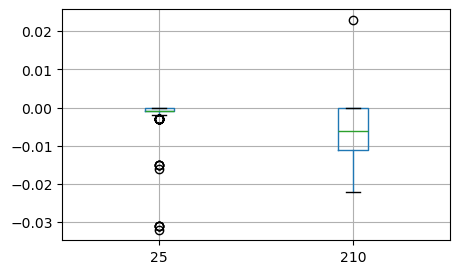

count      mean       std    min    25%    50%  75%    max
25   517.0 -0.001195  0.003373 -0.032 -0.001 -0.001  0.0  0.000
210  516.0 -0.006494  0.006169 -0.022 -0.011 -0.006  0.0  0.023

In [10]:
 ## recalculer df_bf, noté df_rb_wd, par combinaison 1GY, 2GY
df_rb_wd = df_1gy_wd.multiply(df_wt_wd.w1, axis =0) + df_2gy_wd.multiply(df_wt_wd.w2, axis =0)
df_rb_wd = df_rb_wd.round(3)
df_rb_wd_diff = df_rb_wd - df_bf_wd

df_rb_wd_diff.boxplot(figsize = (5,3))
plt.show()
df_rb_wd_diff.describe().T

In [11]:
fig, ax = plt.subplots(1,2, figsize = (12,3))
df_rb_wd_diff[[25]].plot(ax = ax[0])
df_rb_wd_diff[[210]].plot(ax = ax[1])
[ax[i].grid() for i in range(2)]
plt.suptitle("BF: Rebuilt - Bloomberg")
plt.show()

# Forward fill, ensuite exclure les week-ends 
**Methode retenue** Il faut faire le forward fill avec les données brutes, sans supression les week-end
* Security 25: la différence est petite, mais que de différence negative, l'écart est assez petit, min = -0.003
* security 210: la différence est que négative, mais peut être très grande, l'écart est grand min=-0.02
* **Note**: l'échelle de différence est toujours un multiple de 0.001 à cause de l'arrondi 

In [12]:
## forward fill 1GY, 2GY, 1FY, 2FY
df_1gy_wd = ffill_year(df_1gy)
df_2gy_wd = ffill_year(df_2gy)
df_1fy_wd = ffill_year(df_1fy)
df_2fy_wd = ffill_year(df_2fy)

In [13]:
# Exclure les weekend
df_bf_wd = df_bf[df_bf.index.weekday<=4]
df_1gy_wd = df_1gy_wd[df_1gy_wd.index.weekday<=4]
df_2gy_wd = df_2gy_wd[df_2gy_wd.index.weekday<=4]
df_1fy_wd = df_1fy_wd[df_1fy_wd.index.weekday<=4]
df_2fy_wd = df_2fy_wd[df_2fy_wd.index.weekday<=4]

In [14]:
## defini weight
df_wt_wd = pd.DataFrame(data = (df_bf_wd.index.year, df_bf_wd.index.dayofyear),
                         columns = df_bf_wd.index,
                         index = ['year', 'dayofyear']).T
df_wt_wd['dayofyear'] = df_wt_wd.groupby('year')['year'].cumcount()+1
df_wt_wd['nb_days'] = df_wt_wd.year.map(df_wt_wd.groupby('year')['year'].count())
df_wt_wd['w1'] = 1-df_wt_wd.dayofyear/df_wt_wd.nb_days
df_wt_wd['w2'] = df_wt_wd.dayofyear/df_wt_wd.nb_days

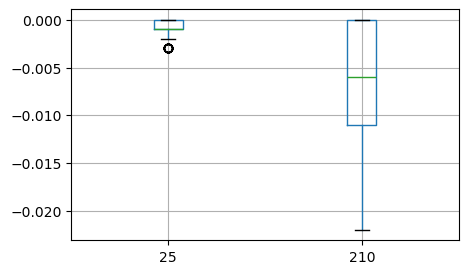

count      mean       std    min    25%    50%  75%  max
25   520.0 -0.000756  0.000755 -0.003 -0.001 -0.001  0.0  0.0
210  520.0 -0.006558  0.006017 -0.022 -0.011 -0.006  0.0  0.0

In [15]:
 ## recalculer df_bf, noté df_rb_wd, par combinaison 1GY, 2GY
df_rb_wd = df_1gy_wd.multiply(df_wt_wd.w1, axis =0) + df_2gy_wd.multiply(df_wt_wd.w2, axis =0)
df_rb_wd = df_rb_wd.round(3)
df_rb_wd_diff = df_rb_wd - df_bf_wd

df_rb_wd_diff.boxplot(figsize = (5,3))
plt.show()
df_rb_wd_diff.describe().T

In [16]:
fig, ax = plt.subplots(1,2, figsize = (12,3))
df_rb_wd_diff[[25]].plot(ax = ax[0])
df_rb_wd_diff[[210]].plot(ax = ax[1])
[ax[i].grid() for i in range(2)]
plt.suptitle("BF: Rebuilt - Bloomberg")
plt.show()

# Forward fill, garder le week-ends

L'écart des valeurs sont petit, mais il y a des sauts alternés: Positif-negatif
* **Note**: l'échelle de différence est toujours un multiple de 0.001 à cause de l'arrondi 

In [17]:
## forward fill 1GY, 2GY, 1FY, 2FY
df_bf_all = df_bf.copy()
df_1gy_all = ffill_year(df_1gy)
df_2gy_all = ffill_year(df_2gy)
df_1fy_all = ffill_year(df_1fy)
df_2fy_all = ffill_year(df_2fy)

In [18]:
## defini weight
df_wt_all = pd.DataFrame(data = (df_bf_all.index.year, df_bf_all.index.dayofyear),
                         columns = df_bf_all.index,
                         index = ['year', 'dayofyear']).T
df_wt_all['dayofyear'] = df_wt_all.groupby('year')['year'].cumcount()+1
df_wt_all['nb_days'] = df_wt_all.year.map(df_wt_all.groupby('year')['year'].count())
df_wt_all['w1'] = 1-df_wt_all.dayofyear/df_wt_all.nb_days
df_wt_all['w2'] = df_wt_all.dayofyear/df_wt_all.nb_days

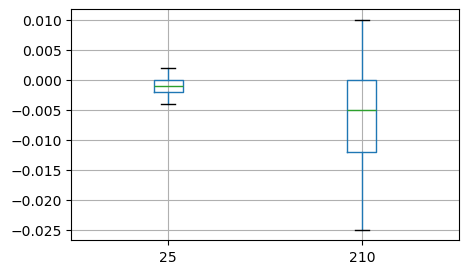

count      mean       std    min    25%    50%  75%    max
25   730.0 -0.000805  0.001067 -0.004 -0.002 -0.001  0.0  0.002
210  730.0 -0.005748  0.007920 -0.025 -0.012 -0.005  0.0  0.010

In [19]:
 ## recalculer df_bf, noté df_rb_wd, par combinaison 1GY, 2GY
df_rb_all = df_1gy_all.multiply(df_wt_all.w1, axis =0) + df_2gy_all.multiply(df_wt_all.w2, axis =0)
df_rb_all = df_rb_all.round(3)
df_rb_all_diff = df_rb_all - df_bf_all

df_rb_all_diff.boxplot(figsize = (5,3))
plt.show()
df_rb_all_diff.describe().T

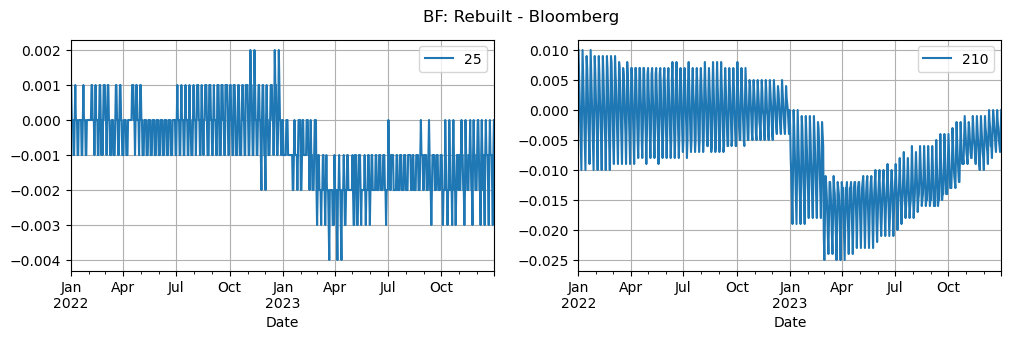

In [20]:
fig, ax = plt.subplots(1,2, figsize = (12,3))
df_rb_all_diff[[25]].plot(ax = ax[0])
df_rb_all_diff[[210]].plot(ax = ax[1])
[ax[i].grid() for i in range(2)]
plt.suptitle("BF: Rebuilt - Bloomberg")
plt.show()

# Généraliser sur l'universe
* On essaie de trouver les poids utilisée par Bloomberg pour calculer BF
  * Pas tous les stocks ont de même l'année fiscale (01 janvier au 31 décembre).
  * **question: comment déterminer l'année fiscale de chaque stock?:**
     * *W:\Global_Research\Quant_research\projets\KC Datasets\_Datasets Offer\_work\erp\_work*
  * Ces stocks sont exclus de la comparaison
* On recalcule BF avec la méthodologie de bloom et compare avec bloomberg
  * 6 stocks on une différence > 5%. Certes, les valeurs BF de ces stocks sont très petites, en plus sont arrondies à 3 décimales, cette différence peut être ignorée.

In [21]:
## Load data from SQL
df_data_dict = pd.read_sql("""select attribute_id, name
                               from QUANT_work..FUNDAMENTAL_DATA_DICTIONARY""", con_mis)
df_data_dict = df_data_dict.set_index('attribute_id')['name']
df_daily_db = pd.read_sql('select * from QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_api_test_100_stocks', con_mis)
df_daily_db.DATE = pd.to_datetime(df_daily_db.DATE)
df_daily_db.attribute_id = df_daily_db.attribute_id.replace(df_data_dict)
df_daily = df_daily_db.set_index(['DATE', 'attribute_id', 'security_id'])
df_daily_ts = df_daily_db.set_index(['security_id', 'attribute_id', 'DATE']).value.unstack().T

## Recupérer EPS 1GY, 2GY, BF en format time series

In [22]:
# separate 1gy, 2gy, bf data
df_1gy = df_daily_db[df_daily_db.attribute_id=='eps_1gy'].set_index(['DATE', 'security_id']).value.unstack()
df_2gy = df_daily_db[df_daily_db.attribute_id=='eps_2gy'].set_index(['DATE', 'security_id']).value.unstack()
df_bf = df_daily_db[df_daily_db.attribute_id=='eps_bf'].set_index(['DATE', 'security_id']).value.unstack()

sec_common = df_1gy.columns.intersection(df_2gy.columns).intersection(df_bf.columns)
date_common = pd.bdate_range('20220101', '20231231')
# keep securities listed since 20220101
listing_date =pd.to_datetime (rep.mapping_from_security(sec_common, code = 'begin_date_min'))
listing_date = listing_date[listing_date<=pd.to_datetime('20220101')]
sec_common = listing_date.index
ticker = rep.mapping_from_security(sec_common, 'fund_ticker')
ticker = ticker.to_frame('fund_ticker')
ticker['td_id'] = rep.mapping_from_security(sec_common, 'prim_td_id')

df_1gy = df_1gy.reindex(index = date_common, columns = sec_common)
df_2gy = df_2gy.reindex(index = date_common, columns = sec_common)
df_bf = df_bf.reindex(index = date_common, columns = sec_common)
df_bf_db = df_bf.stack()

## Compute weight of bloomberg from 1gy, 2gy, BF
Assume that there are 260 trading days every year, and $x$ is the $day^{th}$ of the year we have:
$$
\dfrac{x}{260}\times 1GY + \dfrac{260 - x}{260}\times 2GY = BF
$$
We can determine:
$$x = 260\times\dfrac{BF-2GY}{1GY - 2GY}$$

**Conclusion**
* Pas tous les stocks on la même l'année fiscale.

In [23]:
def day_of_year(gy1,gy2,bf):
    x = 260*(bf-gy2)/(gy1-gy2)
    return x

In [24]:
df_1gy_ffill = ffill_year(df_1gy)
df_2gy_ffill = ffill_year(df_2gy)
df_bf_comp = pd.concat((df_1gy_ffill.stack(), df_2gy_ffill.stack(), df_bf_db), axis = 1).dropna()
df_bf_comp.index.names = ['DATE','security_id']
df_bf_comp.columns = ['1gy', '2gy', 'bf_bbg']

In [25]:
df_wt_bbg = pd.DataFrame(columns = ticker.index)
df_wt_rb = pd.DataFrame(columns = ticker.index)
for sec in df_wt_bbg.columns:
    df = df_bf_comp[df_bf_comp.index.get_level_values('security_id')==sec]
    df = df.reset_index().drop(columns = ['security_id']).set_index('DATE')
    x = day_of_year(df['1gy'], df['2gy'], df['bf_bbg'])
    df_wt_bbg[sec] = x.round(0)

In [26]:
# securities id dont l'année fiscale ne commencent pas en 01 janvier,
# ajout 15210 un cas où le BF est dispo entre 2023-05-24 et 2023-11-24 (pas end of year)
print('securities id dont l année fiscale ne commencent pas en 01 janvier')
sec_anom = df_wt_bbg.columns[(df_wt_bbg.loc['20231229'].abs()>3) | (df_wt_bbg.loc['20221230'].abs()>3)]
sec_anom = ticker.loc[sec_anom].sort_values(by = ['td_id']).index.union([15210])
df_anom = df_wt_bbg[sec_anom]
ticker.loc[sec_anom].T

securities id dont l année fiscale ne commencent pas en 01 janvier


258     11963    15210   15726    17821     18590   18678    \
fund_ticker   SW FP  SOI FP  GIMB BB  SII FP  LOGN SW  CLASB SS  AFX GR   
td_id             1       1       26       1       18        17       2   

            38718   38763   47044    1037829 2632714 2752161  2757656 2764531  \
fund_ticker  PZC LN  RSW LN  EZJ LN  OCDO LN  FGA FP  HBH GR  ACAD SS  LXI LN   
td_id            34      34      34       34       1       2       17      34   

            2907194 2925627  
fund_ticker  TRN LN  CCR LN  
td_id            34      34

In [28]:
df_anom.head()

258      11963    15210    15726    17821    18590    18678    \
DATE                                                                        
2022-01-03    171.0     63.0      NaN     63.0     62.0     84.0    193.0   
2022-01-04    170.0     62.0      NaN     62.0     62.0     84.0    192.0   
2022-01-05    169.0     61.0      NaN     61.0     61.0     81.0    191.0   
2022-01-06    168.0     60.0      NaN     60.0     60.0     81.0    191.0   
2022-01-07    168.0     59.0      NaN     59.0     59.0     79.0    190.0   

            38718    38763    47044    1037829  2632714  2752161  2757656  \
DATE                                                                        
2022-01-03    116.0    128.0    193.0    235.0     63.0     39.0    128.0   
2022-01-04    116.0    126.0    192.0    236.0     62.0     39.0    126.0   
2022-01-05    116.0    126.0    191.0    236.0     61.0     38.0    125.0   
2022-01-06    116.0    124.0    190.0    232.0     60.0     38.0    124.0   
2022-01-07    116.0    124.0    190.0    232.0     59.0     36.0    124.0   

            2764531  2907194  2925627  
DATE                                   
2022-01-03     52.0     41.0     39.0  
2022-01-04     52.0     37.0     39.0  
2022-01-05     52.0     37.0     37.0  
2022-01-06     52.0     37.0     37.0  
2022-01-07     52.0     37.0     36.0

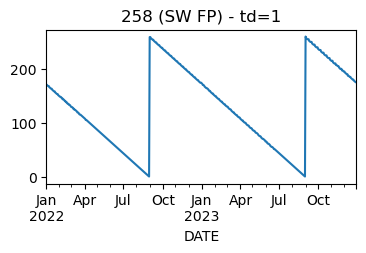

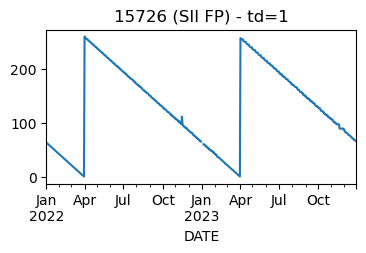

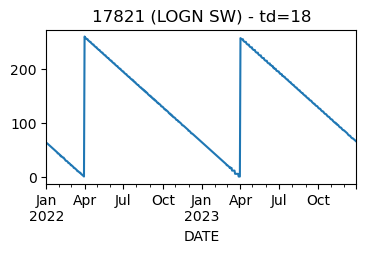

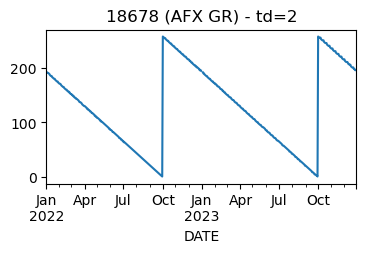

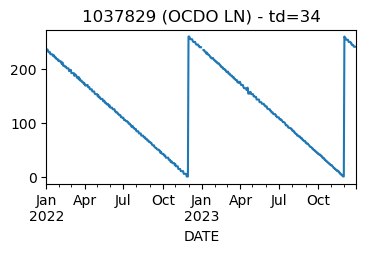

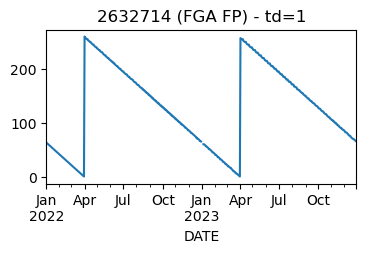

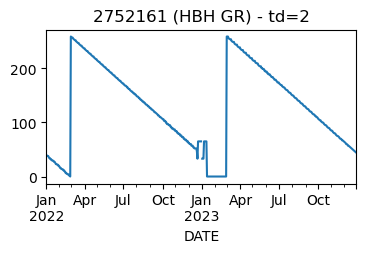

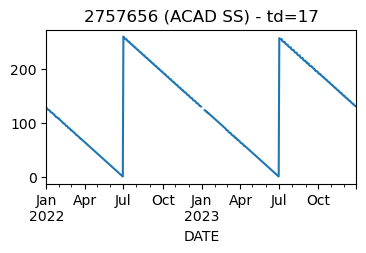

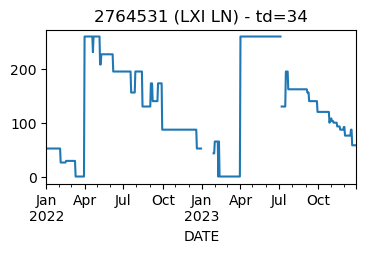

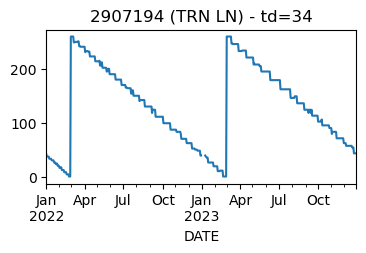

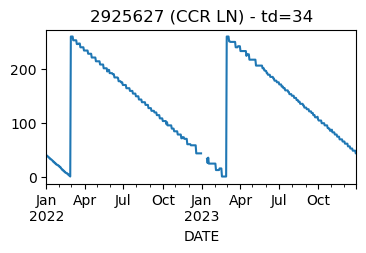

In [29]:
for sec in sec_anom:
    x = df_wt_bbg[sec]
    x.plot(figsize =(4,2), title = '%s (%s) - td=%s'%(sec, ticker.loc[sec,'fund_ticker'], ticker.loc[sec,'td_id']))
    plt.show()

## Rebuilt BF
* $ W^{1gy}_d = \dfrac{N_y - d}{N_y}=1-\dfrac{d}{N_y}$
* $ W^{2gy}_d = \dfrac{d}{N_y}$
* $BF_d = 1GY_d \times W^{1gy}_d + 2GY_d \times W^{2gy}_d$
* Où:
    * $N_y$: nombre de jours trading de l'année y (260-261 jours/an)
    * d: $d^{ème}$ jour trading de l'année

Dans cette partie, on va exclure des securities au-dessus.
|             | 258   | 11963   | 15210   | 15726   | 17821   | 18590    | 18678   | 38718   | 38763   | 47044   | 1037829   | 2632714   | 2752161   | 2757656   | 2764531   | 2907194   | 2925627   |
|:------------|:------|:--------|:--------|:--------|:--------|:---------|:--------|:--------|:--------|:--------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|
| fund_ticker | SW FP | SOI FP  | GIMB BB | SII FP  | LOGN SW | CLASB SS | AFX GR  | PZC LN  | RSW LN  | EZJ LN  | OCDO LN   | FGA FP    | HBH GR    | ACAD SS   | LXI LN    | TRN LN    | CCR LN    |
| td_id       | 1     | 1       | 26      | 1       | 18      | 17       | 2       | 34      | 34      | 34      | 34        | 1         | 2         | 17        | 34        | 34        | 34        |

In [30]:
df_wt_wd = pd.DataFrame(data = (df_bf.index.year, df_bf.index.dayofyear),
                         columns = df_bf.index,
                         index = ['year', 'dayofyear']).T
df_wt_wd['dayofyear'] = df_wt_wd.groupby('year')['year'].cumcount()+1
df_wt_wd['nb_days'] = df_wt_wd.year.map(df_wt_wd.groupby('year')['year'].count())
df_wt_wd['w1'] = 1-df_wt_wd.dayofyear/df_wt_wd.nb_days
df_wt_wd['w2'] = df_wt_wd.dayofyear/df_wt_wd.nb_days

In [31]:
# BF rebuilt, arrondi à 3 decimales
df_bf_rb = (df_1gy_ffill.multiply(df_wt_wd.w1, axis = 0) + df_2gy_ffill.multiply(df_wt_wd.w2, axis = 0))
df_bf_rb_db = df_bf_rb.stack()

In [32]:
df_bf_comp['bf_rb'] = df_bf_rb.stack()
df_bf_comp['diff'] = df_bf_comp.bf_bbg-df_bf_comp.bf_rb
df_bf_comp['diff_rel'] = (df_bf_comp.bf_bbg-df_bf_comp.bf_rb)/df_bf_comp.bf_bbg
## exclure sec anomalies
df_bf_comp = df_bf_comp[~df_bf_comp.index.get_level_values('security_id').isin(sec_anom)]

In [33]:
seuil = 0.05
df_diff = df_bf_comp[df_bf_comp['diff_rel'].abs()>seuil]
sec_diff = df_diff.index.get_level_values('security_id').drop_duplicates()
ticker.loc[sec_diff].T

security_id  2743482  2905367   2168769  13373   2962159   363239 
fund_ticker  CLNX SM  ULTI NO  PHARM NA  AGFB BB  NOL NO  ALGAU FP
td_id             22       72        38       26      72         1

In [34]:
for sec in sec_diff:
    print('---------------- %s (%s), td_id = %s -----------------'%(sec, ticker.loc[sec,'fund_ticker'], ticker.loc[sec,'td_id']))
    print(df_diff[df_diff.index.get_level_values('security_id')==sec])

---------------- 2743482 (CLNX SM), td_id = 22 -----------------
                          1gy    2gy  bf_bbg    bf_rb     diff  diff_rel
DATE       security_id                                                  
2022-02-24 2743482     -0.046  0.169  -0.013 -0.01375  0.00075 -0.057692
---------------- 2905367 (ULTI NO), td_id = 72 -----------------
                          1gy     2gy  bf_bbg     bf_rb      diff  diff_rel
DATE       security_id                                                     
2022-04-18 2905367     -6.607  12.355  -1.013 -1.064262  0.051262 -0.050604
2022-04-19 2905367     -6.607  12.355  -0.940 -0.991331  0.051331 -0.054607
2022-04-20 2905367     -6.607  12.355  -0.868 -0.918400  0.050400 -0.058065
2022-04-21 2905367     -6.607  12.355  -0.795 -0.845469  0.050469 -0.063483
2022-04-25 2905367     -6.607  12.355  -0.650 -0.699608  0.049608 -0.076320
...                       ...     ...     ...       ...       ...       ...
2023-05-29 2905367     -3.837   7.637   0.8